# 금융시장의 빅데이터 분석
## 1차 텀페이퍼
4조 20170632 이혜인, 20180491 김민지, 20180565 안재연<br> <br> 

1) TP 아웃라인<br>
주제 : <b><전기차 산업 관련 뉴스 분석을 통한 대중의 반응과 주가의 상관관계 연구></b>
- 서론  
COVID-19의 여파로 자동차 시장이 침체된 상황에서도 전 세계 친환경차의 판매는 전년 대비 44.6% 증가한 것으로 나타났다. 전기차에 대한 세계적인 관심과 투자가 많은 만큼, 관련된 주식 시장의 움직임도 활발할 것으로 예상한다. 따라서 텀페이퍼를 통해 전기차 산업 관련 이슈에 대한 대중의 반응과 주가 변동의 상관관계를 파악하고자 한다.
- 본론<br>
    - 전기차 산업 관련 뉴스 수집<br>
      - 2020년 11월부터 2021년 4월까지 한국경제, 매일경제에서 보도된 전기차 산업 관련 뉴스 크롤링
    - 뉴스 감정 분석을 통한 대중의 반응 도출<br>
        - google translator API를 이용한 english copus 생성
        - LSTM, GPU 등 ML을 활용한 긍정/부정 감성 예측 모델 생성
      
    - 전기차 관련 주 기초통계량 분석<br>
      - yahoo finanace와 naver/KRX에서 제공하는 국내 전기차 관련주 13종목의 주가 변동 파악
    - 전기차관련 주 회귀분석<br>
        - 분야별 대중의 반응과 주가 변동의 상관관계 분석  
        : 전기차, 배터리, 충전소
- 결론
<br>

2) 기초 통계량<br>
- 뉴스 크롤링<br>
- 주가 종목별 뉴스 개수 추출<br>
- 주가 변동 도출<br>
- 긍정/부정 반응 분석<br>



# 1) 뉴스 크롤링

In [ ]:
#한국경제 뉴스 크롤링

#-*- coding:utf-8 -*-
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
from bs4.element import NavigableString

result = []
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36"}

for i in range(1,6) :
    #크롤링 할 링크 불러오기
    response = get("https://search.hankyung.com/apps.frm/search.news?query=%EC%A0%84%EA%B8%B0%EC%B0%A8&sort=DATE%2FDESC%2CRANK%2FDESC&period=DATE&area=title&mediaid_clust=HKPAPER&sdate=2020.11.01&edate=2020.11.30&exact=&include=&except=&page="+str(i),headers=headers)
    html = response.text
    if response.status_code == 200:
        #파싱
        bsObject = BeautifulSoup(html, 'html.parser')

        for newslist in bsObject.select('div.txt_wrap') :

            #한경 기사만 가져오기
            company = newslist.select_one('.info > span')
            if '한국경제' not in company : continue

            #제목
            newstitle = newslist.select_one('.tit').get_text().lstrip()
            if '[포토]' in newstitle : continue #포토 기사 제외

            #날짜
            newsdate = newslist.select_one('span.date_time').string
            newsdate = newsdate[:10] #시간 제외
            newsdate = newsdate[:4]+'년 '+newsdate[5:7]+'월 '+newsdate[8:]+'일'

            #본문
            url = newslist.a['href']
            response_news = get(url,headers=headers)
            newshtml = response_news.text

            if response_news.status_code == 200:
                bs = BeautifulSoup(newshtml, 'html.parser')
                content = bs.select_one("#articletxt")

                #기사 본문과 상관 없는 하위 태그들 삭제
                target_text_without_child_tags = [
                    bs_object
                    for bs_object
                    in content
                    if isinstance(bs_object, NavigableString)
                ]
                text = "".join(target_text_without_child_tags)
                content = text.strip()

                #기자 삭제
                if '기사제보 및 보도자료 open@hankyung.com' in content :
                    content = content.replace('기사제보 및 보도자료 open@hankyung.com','')
                if '@hankyung.com' in content :
                    index = content.rfind('.',0,len(content)-13)
                    content = content[:index+1]


                #엑셀로 추출
                result.append([newstitle,newsdate,content])
                data = pd.DataFrame(result)
                data.to_csv('November.csv', encoding='cp949') 
            else : 
                print(response_news.status_code)
    else :
        print(response.status_code)
    
    print('success {} page'.format(i))

In [ ]:
#매일경제 뉴스 크롤링

from requests import get
from bs4 import BeautifulSoup
from re import compile
import csv

f = open('write.csv', 'w', newline='')
wr = csv.writer(f)
wr.writerow(['제목', '날짜', '본문'])

for i in range(1, 6) :

    response = get("https://find.mk.co.kr/new/search.php?pageNum="+str(i)+"&cat=&cat1=&media_eco=&pageSize=20&sub=news&dispFlag=OFF&page=news&s_kwd=%C0%FC%B1%E2%C2%F7&s_page=news&go_page=&ord=1&ord1=1&ord2=0&s_keyword=%C0%FC%B1%E2%C2%F7&period=p_direct&s_i_keyword=%C0%FC%B1%E2%C2%F7&s_author=&y1=2020&m1=11&d1=01&y2=2020&m2=11&d2=31&ord=1&area=tt")

    if response.status_code == 200:
        bsObject = BeautifulSoup(response.content.decode('euc-kr','replace'), 'html.parser')

        for newslist in bsObject.select('div.sub_list') :
            #매일경제, 연합뉴스 기사만(연합뉴스 포토 제외)
            newsname = newslist.select_one('span.art_time').string
            if not (newsname[1:5] == '매일경제' or (newsname[1:5] == '연합뉴스' and newsname[6:8] != '포토')) : continue
            
            newsdate = newsname[6:19]

            #제목에 포토 들어간 기사 제외
            newstitle = newslist.select_one('a').get_text()
            if newstitle[:4] == '[포토]' : continue
            if newstitle[:6] == '[경제칼럼]' : continue
            print(newstitle)

            response_news = get(newslist.a['href'])
            if response_news.status_code == 200:
                bs = BeautifulSoup(response_news.content.decode('euc-kr','replace'), 'html.parser')
                content = bs.select('#article_body > div')[0].get_text().lstrip()
                if content[:6] == '[Pulse' : continue
                
                #기자 관련 내용 삭제
                if newsname[1:5] == '매일경제' :
                    #기자 없으면 제외
                    if not bs.select_one('li.author').get_text().rstrip() : continue
                    pat = compile('\[.{1,50}(기자|특파원|교수|위원)')
                    index = pat.search(content).start()
                else :
                    index = content.find('[연합뉴스]')
                content = content[:index]

                wr.writerow([newstitle, newsdate, content])
                print('ok')
            else : 
                print(response_news.status_code)
    else : 
        print(response.status_code)

    print('success {} page'.format(i))

f.close()


# 2) 주가 종목별 뉴스 개수 추출

1. 전기차 관련 주 
- 현대차, 기아차 
<br><br>

2. 배터리(2차전지) 관련 주 
- LG화학/에너지솔루션, 삼성SDI, SK이노베이션
- 양극재 소재주 : 에코프로비엠(삼성), 엘엔에프(LG), 포스코케미칼 
- 음극재 소재주 : 포스코케미칼
<br><br>

3. 충전소 관련주 
- SK네트웍스(현대차), 피앤이솔루션, 피에스텍, 포스코 ICT


In [ ]:
#사전형식으로 추출
#0으로 초기화
data = {'현대차':0,'기아차':0,'LG화학/에너지솔루션':0, '삼성SDI':0, 'SK이노베이션':0,'에코프로비엠':0, '엘앤에프':0, '포스코케미칼':0,'SK네트웍스':0, '피앤이솔루션':0, '피에스텍':0, '포스코ICT':0}

import pandas as pd

#뉴스 
data_pd = pd.read_csv(('November.csv'),encoding='cp949',header = None, index_col=None, names = None)
data_np = pd.DataFrame.to_numpy(data_pd)

#전기차 관련 주
i = 1
for i in range(1,104) :
    title = data_np[i][1]
    if '현대' in title : data['현대차'] += 1
    if '기아' in title : data['기아차'] += 1
    if ('LG화학' or 'LG에너지솔루션') in title : data['LG화학/에너지솔루션'] += 1
    if '삼성SDI' in title : data['삼성SDI'] += 1
    if 'SK이노베이션' in title : data['SK이노베이션'] += 1
    if '에코프로비엠' in title : data['에코프로비엠'] += 1
    if '엘앤에프' in title : data['엘앤에프'] += 1
    if '포스코케미칼' in title : data['포스코케미칼'] += 1
    if 'SK네트웍스' in title : data['SK네트웍스'] += 1
    if '피앤이솔루션' in title : data['피앤이솔루션'] += 1
    if '피에스텍' in title : data['피에스텍'] += 1
    if (('(주)포스코 ICT') or ('POSCO ICT COMPANY LTD.') or ('포스데이타') or ('포스코아이씨티') or ('포스코 ICT') or ('포스코ICT')) in title : data['포스코ICT'] += 1
    i+=1

#데이터 출력
df = pd.DataFrame(data,index=['cnt'])
df = df.transpose()
print(df)


# 3) 주가 변동 도출

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
import yfinance as yf 
from pykrx import stock

In [ ]:
hyundai = yf.download('005380.KS', start='2020-11-01', end='2020-11-30')
kia = yf.download('000270.KS', start='2020-11-01', end='2020-11-30')
lg_chemi = yf.download('051910.KS', start='2020-11-01', end='2020-11-30')
ss_sdi = yf.download('006400.KS', start='2020-11-01', end='2020-11-30')
sk_inov = yf.download('096770.KS', start='2020-11-01', end='2020-11-30')
posco_chemi = yf.download('003670.KS', start='2020-11-01', end='2020-11-30')
sk_net = yf.download('003670.KS', start='2020-11-01', end='2020-11-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

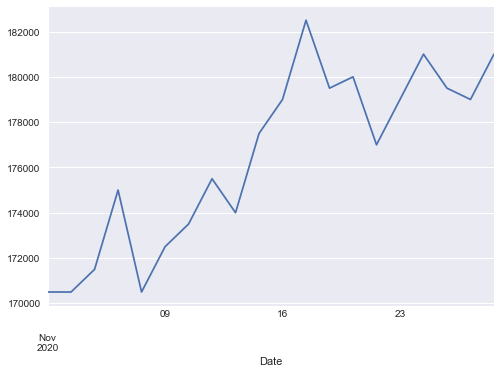

In [ ]:
hyundai.Close.plot()

<AxesSubplot:xlabel='Date'>

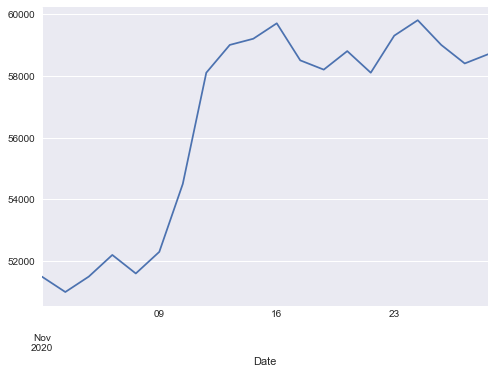

In [ ]:
kia.Close.plot()

<AxesSubplot:xlabel='Date'>

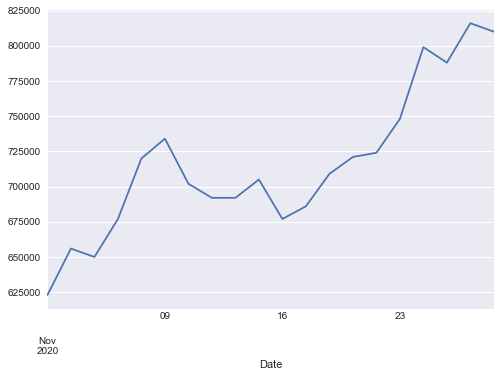

In [ ]:
lg_chemi.Close.plot()

<AxesSubplot:xlabel='Date'>

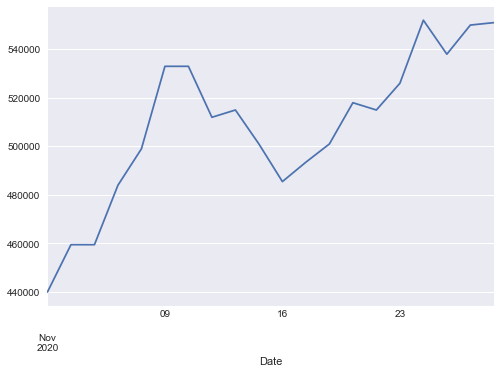

In [ ]:
ss_sdi.Close.plot()

<AxesSubplot:xlabel='Date'>

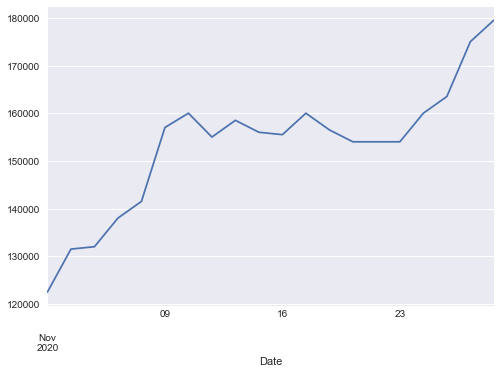

In [ ]:
sk_inov.Close.plot()

<AxesSubplot:xlabel='Date'>

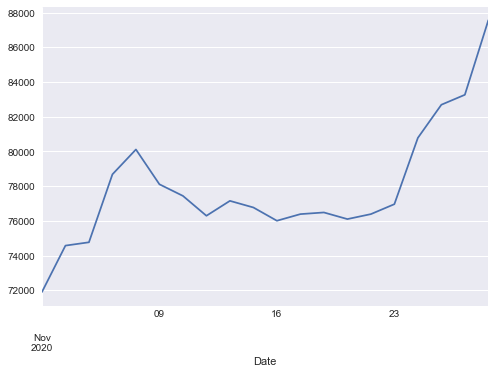

In [ ]:
posco_chemi.Close.plot()

<AxesSubplot:xlabel='Date'>

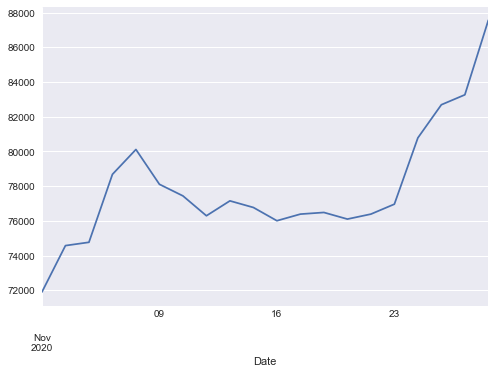

In [ ]:
sk_net.Close.plot()

<AxesSubplot:xlabel='Date'>

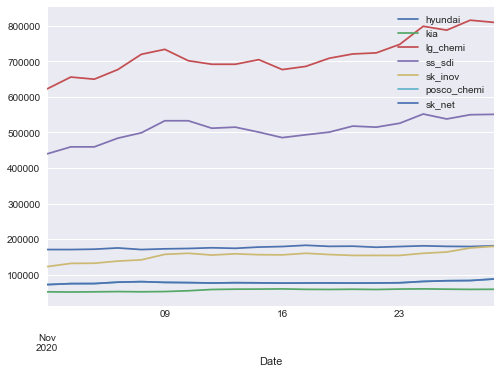

In [ ]:
df = pd.DataFrame() 
df['hyundai'] = hyundai.Close
df['kia'] = kia.Close
df['lg_chemi'] = lg_chemi.Close
df['ss_sdi'] = ss_sdi.Close
df['sk_inov'] = sk_inov.Close
df['posco_chemi'] = posco_chemi.Close
df['sk_net'] = sk_net.Close
df.plot()

In [ ]:
codes = {'247540' : 'ecopro', '066970' : 'lnf', '131390' : 'pne','002230' : 'pstech', '022100' : 'pocso_ict'}
df_kosdaq = pd.DataFrame()
for code, name in codes.items() :
    temp = stock.get_market_ohlcv_by_date("20201101", 
"20201130", code)
    temp = temp.rename(columns={'종가': 'Close'})
    df_kosdaq[name] = temp.Close

In [ ]:
ecopro = stock.get_market_ohlcv_by_date("20201101", "20201130", '247540')
lnf = stock.get_market_ohlcv_by_date("20201101", "20201130", '066970')
pne = stock.get_market_ohlcv_by_date("20201101", "20201130", '131390')
pstech = stock.get_market_ohlcv_by_date("20201101", "20201130", '002230')
posco_ict = stock.get_market_ohlcv_by_date("20201101", "20201130", '022100')

<AxesSubplot:xlabel='날짜'>

c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-pac

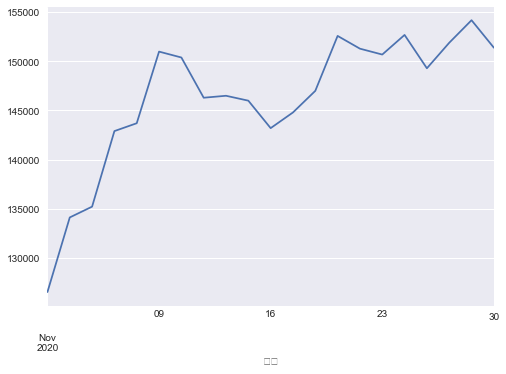

In [ ]:
ecopro['종가'].plot()

<AxesSubplot:xlabel='날짜'>

c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-pac

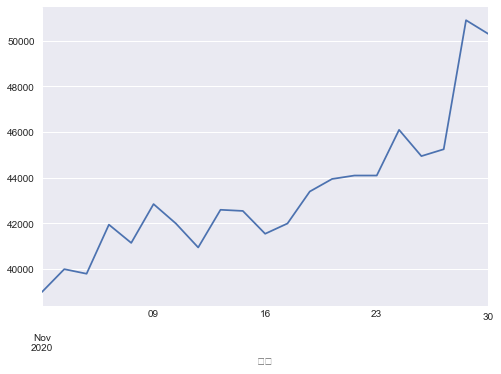

In [ ]:
lnf['종가'].plot()

<AxesSubplot:xlabel='날짜'>

c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-pac

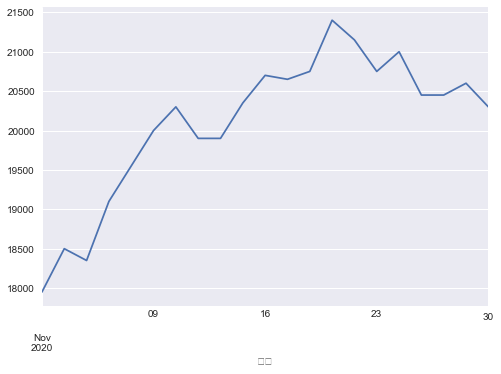

In [ ]:
pne['종가'].plot()

<AxesSubplot:xlabel='날짜'>

c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-pac

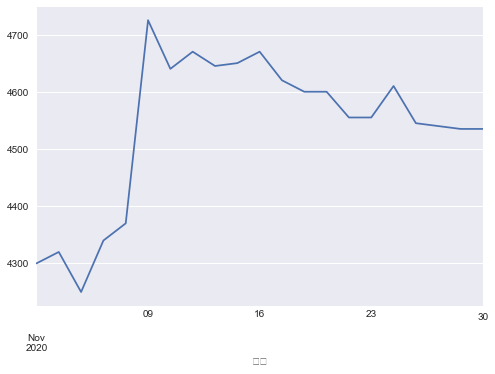

In [ ]:
pstech['종가'].plot()

<AxesSubplot:xlabel='날짜'>

c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-pac

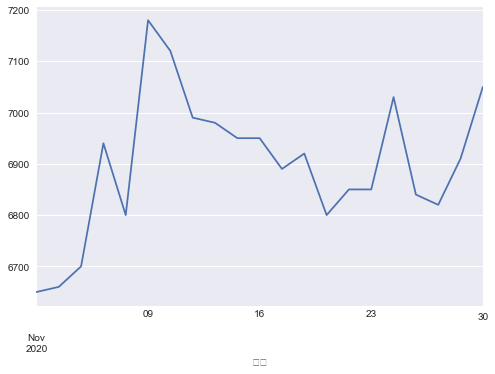

In [ ]:
posco_ict['종가'].plot()

In [ ]:
df_kosdaq = pd.DataFrame()
df_kosdaq['ecopro'] = ecopro['종가']
df_kosdaq['lnf'] = lnf['종가']
df_kosdaq['pne'] = pne['종가']
df_kosdaq['pstech'] = pstech['종가']
df_kosdaq['posco_ict'] = ecopro['종가']

<AxesSubplot:xlabel='날짜'>

c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\user\Desktop\금융시장의빅데이터분석\myvenv\lib\site-pac

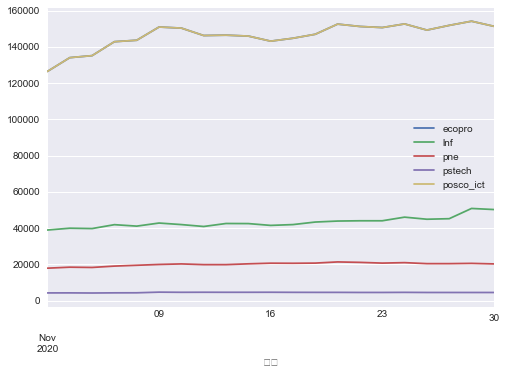

In [ ]:
df_kosdaq.plot()

# 4) 기사 긍정/부정 반응 분석

## import

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [9]:
import datetime as dt

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news_1=pd.read_csv("/content/drive/MyDrive/금융시장빅데이터분석/BD_data1.csv", encoding ='cp949')
news_2=pd.read_csv("/content/drive/MyDrive/금융시장빅데이터분석/BD_data2.csv", encoding ='cp949')
news_3=pd.read_csv("/content/drive/MyDrive/금융시장빅데이터분석/BD_data3.csv", encoding ='cp949')
news_4=pd.read_csv("/content/drive/MyDrive/금융시장빅데이터분석/BD_data4.csv", encoding ='cp949')

### korean nlp module

In [5]:
pip install konlpy

     |████████████████████████████████| 19.4MB 50.1MB/s 
     |████████████████████████████████| 460kB 37.8MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [6]:
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

### translate -google API

In [7]:
pip install googletrans==4.0.0-rc1

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 1.0MB 11.0MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-cp37-none-any.whl size=17417 sha256=87585a4b9ed7dcc8345434d760202b7015ec0c8fae4e99ed28d155e267f03caf
  Stored in directory: /root/.cache/pip/wheels/09/32/56/fd8940f1b3c1d77c9f91b55597c52a4d4833b000a980bb0740
Successfully built googletrans


In [8]:
from googletrans import Translator
translator = Translator()

### nlp module

In [9]:
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer 

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
eng_stopwords = set(stopwords.words("english"))

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [13]:
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

In [14]:
!pip install contractions

     |████████████████████████████████| 286kB 5.2MB/s 
     |████████████████████████████████| 327kB 37.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85392 sha256=888cfa8ae0ee01ae652c97a5cb457b48159a8a5bed5440b3ae49f49983b8e8ad
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [15]:
import contractions # 사용법 : contractions.fix(test_text)

### text_en 전처리 함수

In [16]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [17]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n"," ",comment)

    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    clean_sent=re.sub("\W+"," ",clean_sent)
    clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [18]:
# remove exceopt (A to Z)
def A_to_Z(text):
    clean_sent=re.sub(r"[^a-zA-z]",r' ', text)
    clean_sent=re.sub("  "," ",clean_sent)
    return clean_sent

In [19]:
# change to contractions
def contractions_(text):
    return contractions.fix(text)

## 데이터 통합

In [ ]:
news_1=news_1.dropna()
news_2=news_2.dropna()
news_3=news_3.dropna()
news_4=news_4.dropna()

In [ ]:
news_1=news_1.drop_duplicates(['text'])
news_2=news_2.drop_duplicates(['text'])
news_3=news_3.drop_duplicates(['text'])
news_4=news_4.drop_duplicates(['text'])

In [ ]:
data_origin=pd.concat([news_1,news_2,news_3,news_4], ignore_index=True)
data_origin

,title,date,time,text,tume,Unnamed: 0
0,"자율주행 대명사 '테슬라', 美 평가서 2년 연속 '꼴찌'",2021-04-29,18:36,최근 실적발표에서 전기차보다 '가상화폐' 판매로 수익을 올린 것으로 드러난 미국 전...,NaN,NaN
1,"LG전자, 매출·영업이익 모두 사상 최대…프리미엄 가전의 힘",2021-04-29,15:37,LG전자가 프리미엄 가전의 성장세에 힘입어 사상 최대 실적을 수확했다.\nLG전자...,NaN,NaN
2,"기아-SK이노, 전기차 배터리 재활용 협력…“배터리 순환경제 본격화”",2021-04-29,13:10,기아와 SK이노베이션이 전기차용 배터리 순환경제 구축을 위해 협력한다.\n양사는 사...,NaN,NaN
3,"한국, 수소전기차 보급률 세계 1위인데… 인프라 수준은 뒤에서 2등",2021-04-28,20:00,수소전기차(FCEV) 보급률 1위인 대한민국의 충전 인프라 구축은 전 세계 최하위권...,NaN,NaN
4,“3000억도 뚫었다”… LG엔솔 분기 영업이익 사상 최대치,2021-04-28,17:51,LG에너지솔루션이 올해 1분기에 '깜짝실적'(어닝서프라이즈)을 달성했다. \nLG화...,NaN,NaN
...,...,...,...,...,...,...
2605,"일본전산, 유럽에 전기차 모터 공장 설립\r\n ...",2020년 11월 02일,17:31,일본 기업들이 전기자동차(EV) 시장의 주도권을 확보하기 위해 대대적인 투자에 나섰...,NaN,268.0
2606,현대차 '넥쏘' 국내판매 1만대 돌파…수소전기차 대중화 '가속페달'\r\n ...,2020년 11월 02일,15:14,현대자동차가 세계 최초로 수소전기차 판매 1만 대를 달성했다. 대형 수소전기트럭도 ...,NaN,269.0
2607,"[숫자로 읽는 세상] 모건스탠리 2030년 세계 車 시장, 전기차 비중 31%\r\...",2020년 11월 02일,9:01,10년 뒤 세계 자동차 시장에서 전기차가 차지하는 비중이 30%를 넘어설 것이라는 ...,NaN,270.0
2608,"이테스, 베트남 빈패스트社…전기차 충전 시스템 수주\r\n ...",2020년 11월 01일,18:03,전기자동차 배터리팩업체인 이테스가 베트남 전기차업체 빈패스트의 전기차용 충전 시스템...,NaN,271.0


In [ ]:
len(data_origin)

2610

In [ ]:
# datetime 객체로 변환
data_origin['date'] = pd.to_datetime(data_origin['date'], format='%Y-%m-%d')  

In [ ]:
# index를 datetime 객체로 설정
data=data_origin[['date','text']]
data=data.set_index(['date'])
data=data.sort_index()
data

,text
date,
2020-11-01,지난 7월 현대자동차의 대형 수소전기 트럭 ‘엑시언트’ 10대가 스위스로 향하는 선...
2020-11-01,국토교통부는 규제혁신심의위원회를 열고 전기차 전용 정비업체 등록기준 완화 등 총 1...
2020-11-01,정부가 전기차 구매보조금 구조를 '하후상박' 형태로 바꾼다. 코나EV 등 상대적으로...
2020-11-01,전기자동차 배터리팩업체인 이테스가 베트남 전기차업체 빈패스트의 전기차용 충전 시스템...
2020-11-01,정부가 지난달 30일 발표한 ‘미래 자동차 확산 및 시장선점 전략’에서 전기차 보조...
...,...
2021-04-30,국내 전기차 배터리 업계 1위인 LG에너지솔루션이 사업 확장에 나선다. LG에너지솔...
2021-04-30,구리 가격이 2011년 이후 처음으로 29일(현지시간) 톤(t)당 1만달러(약 11...
2021-04-30,폭스바겐은 지난 28일(현지시간) 독일 베를린에 있는 템펠호프 공항 항공기 격납고에...


In [ ]:
data_stack=data.stack()
data_stack

date            
2020-11-01  text    지난 7월 현대자동차의 대형 수소전기 트럭 ‘엑시언트’ 10대가 스위스로 향하는 선...
            text    국토교통부는 규제혁신심의위원회를 열고 전기차 전용 정비업체 등록기준 완화 등 총 1...
            text    정부가 전기차 구매보조금 구조를 '하후상박' 형태로 바꾼다. 코나EV 등 상대적으로...
            text    전기자동차 배터리팩업체인 이테스가 베트남 전기차업체 빈패스트의 전기차용 충전 시스템...
            text    정부가 지난달 30일 발표한 ‘미래 자동차 확산 및 시장선점 전략’에서 전기차 보조...
                                          ...                        
2021-04-30  text    국내 전기차 배터리 업계 1위인 LG에너지솔루션이 사업 확장에 나선다. LG에너지솔...
            text    구리 가격이 2011년 이후 처음으로 29일(현지시간) 톤(t)당 1만달러(약 11...
            text    폭스바겐은 지난 28일(현지시간) 독일 베를린에 있는 템펠호프 공항 항공기 격납고에...
            text    화웨이가 중국 전기차 제조사를 인수해 직접 친환경차 시장에 뛰어들 것이라는 전망이 ...
            text    폭스바겐, 220kW 고성능 순수전기차 `신형 ID.4 GTX` 공개 [사진제공=폭...
Length: 2610, dtype: object

## 시계열 데이터 생성

In [ ]:
index=data.index
index=index.drop_duplicates()
index

DatetimeIndex(['2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04',
               '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10',
               ...
               '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
               '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28',
               '2021-04-29', '2021-04-30'],
              dtype='datetime64[ns]', name='date', length=181, freq=None)

In [ ]:
date_index=pd.date_range('2020-11-01','2021-04-30')
date_index

DatetimeIndex(['2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04',
               '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10',
               ...
               '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
               '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28',
               '2021-04-29', '2021-04-30'],
              dtype='datetime64[ns]', length=181, freq='D')

In [ ]:
# 일별 뉴스 갯수
news_num=[]
for i in date_index:
    try:
        news_num.append(len(data_stack[i]))
    except:
        news_num.append(0)
len(news_num)

181

In [ ]:
# 특정 기업 언급 횟수
hyundai=[]
kia=[]
for i in date_index:
    H=0
    K=0
    try:
        text_stack=data_stack[i]
        for j in text_stack :
            words=tokenizer.tokenize(j)

            if '현대' in words : H+=1
            if '기아' in words : K+=1
    except:
        pass
    hyundai.append(H)
    kia.append(K)
len(hyundai)
len(kia)

181

In [ ]:
timeseries=pd.DataFrame({"기사 수":news_num, "현대" : hyundai, "기아":kia }, index=date_index)
timeseries

,기사 수,현대,기아
2020-11-01,5,1,0
2020-11-02,12,0,0
2020-11-03,11,0,0
2020-11-04,11,0,1
2020-11-05,4,0,0
...,...,...,...
2021-04-26,27,1,3
2021-04-27,19,0,1
2021-04-28,15,0,1
2021-04-29,20,1,6


In [ ]:
timeseries.describe()

,기사 수,현대,기아
count,181.000000,181.000000,181.000000
mean,14.419890,0.696133,1.491713
std,10.571999,1.312943,2.407439
min,1.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000
75%,20.000000,1.000000,2.000000
max,49.000000,11.000000,12.000000


## 데이터 전처리

In [ ]:
data_stack[0]

'지난 7월 현대자동차의 대형 수소전기 트럭 ‘엑시언트’ 10대가 스위스로 향하는 선박에 올랐다. 현대차는 앞서 수소전기 트럭을 납품하기 위해 현지 기업들과 공급계약을 맺었다. 세계 처음으로 수소전기 트럭 양산 체제를 갖추고 수출까지 성공한 것이다.그로부터 한 달 뒤인 8월, 현대차는 전기차 전용 플랫폼을 제작하겠다는 계획을 밝혔다. 내연기관차에 전기차 배터리를 넣는 게 아니라 처음부터 전기차만을 위한 뼈대와 구조물을 바탕으로 설계하겠다는 발표였다. 플랫폼 제작에는 오랜 시간과 수천억원의 비용이 투입된다. 현대차가 친환경차에 승부수를 던졌다는 평가가 나오는 배경이다.이 같은 현대차에 대한 평가는 ‘한경-입소스-피앰아이 기업 소셜임팩트 조사’에서도 나타났다. 현대차는 친환경차 부문(전기차·수소차·하이브리드 포함)에서 41.7%의 평가를 받아 2위인 테슬라(24.9%)를 제쳤다. 10명 중 4명이 현대차를 가장 선호하는 기업으로 꼽았다. 3위가 기아자동차(12.4%), 4위 메르세데스벤츠(5.4%), 5위는 BMW(5.0%)였다.현대차가 ‘전기차 강자’ 테슬라를 뛰어넘은 것은 최근 친환경차 라인업을 전방위적으로 넓히는 것과 관련이 깊다는 분석이다. 테슬라는 전기차 부문에서 선두를 달리고 있지만 수소차 부문에서는 별다른 성과를 내지 못하고 있다. 이에 비해 현대차는 수소차와 전기차 모두에 역량을 집중하는 ‘투 트랙’ 전략을 펼치고 있다. 스위스 수출로 수소전기차 분야에서 ‘압도적 1위’라는 평가를 받은 데 이어 전기차 시장에서는 기아차와 함께 글로벌 점유율 4위(올 1~8월 기준)에 올랐다. 국내 소비자 사이에서 테슬라의 사후서비스(AS)에 대한 불만이 커진 것도 현대차가 우위를 점한 요인이 됐다. 현대차는 내연기관차 부문에서도 38.5%의 평가를 받아 ‘명실상부’ 1위 자리를 굳혔다. 기아차는 17.1%로 2위에 올랐다. 메르세데스벤츠(11.6%), 르노삼성자동차(7.2%)와 BMW(7.2%)가 뒤를 이었다.입소스 관계자는 “자동차는 소비자가 제품을 구매할 때 시

In [ ]:
# clean_korean
data_stack=data_stack.str.replace("\n"," ")
data_stack=data_stack.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ^a-zA-z]"," ") # 한글과 영어, 공백을 제외하고 모두 제거
data_stack=data_stack.str.replace("  "," ")
data_stack[0]

'지난 월 현대자동차의 대형 수소전기 트럭 엑시언트  대가 스위스로 향하는 선박에 올랐다 현대차는 앞서 수소전기 트럭을 납품하기 위해 현지 기업들과 공급계약을 맺었다 세계 처음으로 수소전기 트럭 양산 체제를 갖추고 수출까지 성공한 것이다 그로부터 한 달 뒤인 월 현대차는 전기차 전용 플랫폼을 제작하겠다는 계획을 밝혔다 내연기관차에 전기차 배터리를 넣는 게 아니라 처음부터 전기차만을 위한 뼈대와 구조물을 바탕으로 설계하겠다는 발표였다 플랫폼 제작에는 오랜 시간과 수천억원의 비용이 투입된다 현대차가 친환경차에 승부수를 던졌다는 평가가 나오는 배경이다 이 같은 현대차에 대한 평가는 한경 입소스 피앰아이 기업 소셜임팩트 조사 에서도 나타났다 현대차는 친환경차 부문 전기차 수소차 하이브리드 포함 에서   의 평가를 받아 위인 테슬라    를 제쳤다  명 중 명이 현대차를 가장 선호하는 기업으로 꼽았다  위가 기아자동차     위 메르세데스벤츠     위는 BMW   였다 현대차가 전기차 강자 테슬라를 뛰어넘은 것은 최근 친환경차 라인업을 전방위적으로 넓히는 것과 관련이 깊다는 분석이다 테슬라는 전기차 부문에서 선두를 달리고 있지만 수소차 부문에서는 별다른 성과를 내지 못하고 있다 이에 비해 현대차는 수소차와 전기차 모두에 역량을 집중하는 투 트랙 전략을 펼치고 있다 스위스 수출로 수소전기차 분야에서 압도적 위 라는 평가를 받은 데 이어 전기차 시장에서는 기아차와 함께 글로벌 점유율 위 올  월 기준 에 올랐다 국내 소비자 사이에서 테슬라의 사후서비스 AS 에 대한 불만이 커진 것도 현대차가 우위를 점한 요인이 됐다 현대차는 내연기관차 부문에서도   의 평가를 받아 명실상부  위 자리를 굳혔다 기아차는   로 위에 올랐다 메르세데스벤츠     르노삼성자동차   와 BMW   가 뒤를 이었다 입소스 관계자는 자동차는 소비자가 제품을 구매할 때 시간과 노력을 많이 들이는 고관여 제품 이라 소셜임팩트가 구매 의향에 크게 영향을 미친다 고 말했다 '

In [ ]:
check=0+100+100
check

2560

In [ ]:
data_translated=[]
for i in range(100):
    encoded = translator.translate(data_stack[i+check][:5000], dest='ko').text
    decoded = translator.translate(encoded, dest='en').text
    data_translated.append(decoded)


In [ ]:
data_translated[0]

"Premium brand Genesis brought the emissions tags to the global market, and Genesis was the first time in the world, the world's first electric car model is the world's first brand first electric vehicle model in the Shanghai International Motor Show in Shanghai Convention Center, Starting on the launch of domestic launches in the first half of this year, we will be sequentially presented to the global market in accordance with each regional schedule, but they decided not to attach a separate model name due to the derivative model of the internal combustion engine, and the price of the vehicle will be released at the time of release. Jang Jae-hoon Genesis President, who shows the dynamic elegance, said G's electric car model will be the beginning to announce the journey of the brand in the EV electric car market. The first luxury EV G preocciative model is the world's first public service, It is a vehicle that presents a new standard of advanced large-sized fairy tale sedan. In additio

In [ ]:
data_en= pd.DataFrame({ "text" :data_translated }, index=data.index[check:len(data_translated)+check])
data_en

In [ ]:
data_en.to_csv(r"/content/drive/MyDrive/금융시장빅데이터분석/translated1.csv")

In [ ]:
en1=pd.read_csv("/content/drive/MyDrive/금융시장빅데이터분석/data_en1.csv")
en2=pd.read_csv("/content/drive/MyDrive/금융시장빅데이터분석/data_en2.csv", encoding ='cp949')

In [ ]:
data_en=pd.concat([en1,en2])
data_en

,date,text
0,2021-01-21,"If you purchase an electric vehicle this year,..."
1,2021-01-21,Hyundai Motor said that we have established Hy...
2,2021-01-21,Hyundai Motor establishes Hyundai EV Station K...
3,2021-01-21,"Joe Biden, the US President of the United Stat..."
4,2021-01-21,SK Energy is the first time in the refining in...
...,...,...
1395,2021-01-21,"When purchasing electric vehicles this year, t..."
1396,2021-01-21,"Since this year, the highest level of electric..."
1397,2021-01-21,"GM General Motors, one of the largest automoti..."
1398,2021-01-21,The government will pay a subsidy near the ele...


In [ ]:
data_en.iloc[0]['text']

"If you purchase an electric vehicle this year, you will receive a maximum number of times from the government and the local government, and the amount of the amount of the amount of hydrogen permits are subsidized as a subsidy. The subsidy for the ultra-small vans and taxi is increasing. From this year, If the price of the vehicle is less than a circle, the subsidy is paid to the subsidy if the price of the vehicle is less than the size of the vehicle. The government announced the full reorganization of the year since the year, the government announced the completion of this subsidy system. The follow-up of the preemption strategy The reorganization of the subsidy subsidy system is that it contains a subsidy and a different if the operation is to give a subsidy and the excellent number of subsidies, and it will give a different case of the contrary. Distance grant supports maximum number of won. It supports up to the maximum number of deductions. It supports the cost of the target sub

In [ ]:
data_en['text'] = data_en['text'].apply(lambda x :clean(x))
data_en.iloc[0]['text']

'purchase electric vehicle year receive maximum number time government local government amount amount amount hydrogen permit subsidize subsidy subsidy ultra small vans taxi increase year price vehicle less circle subsidy pay subsidy price vehicle less size vehicle government announce full reorganization year since year government announce completion subsidy system follow up preemption strategy reorganization subsidy subsidy system contain subsidy different operation give subsidy excellent number subsidies give different case contrary distance grant support maximum number win support maximum number deductions support cost target subsidy target company target company energy efficiency subsidy support new one year energy efficiency since local government add provincial ratio energy payment determine year since year local government proportional local cost example provincial ratio electric vehicle largest support fact price electric vehicle limit fact divide single price limit production e

In [ ]:
data_en['text'] = data_en['text'].apply(lambda x :A_to_Z(x))
data_en.iloc[0]['text']

'purchase electric vehicle year receive maximum number time government local government amount amount amount hydrogen permit subsidize subsidy subsidy ultra small vans taxi increase year price vehicle less circle subsidy pay subsidy price vehicle less size vehicle government announce full reorganization year since year government announce completion subsidy system follow up preemption strategy reorganization subsidy subsidy system contain subsidy different operation give subsidy excellent number subsidies give different case contrary distance grant support maximum number win support maximum number deductions support cost target subsidy target company target company energy efficiency subsidy support new one year energy efficiency since local government add provincial ratio energy payment determine year since year local government proportional local cost example provincial ratio electric vehicle largest support fact price electric vehicle limit fact divide single price limit production e

In [ ]:
data_en['text'] = data_en['text'].apply(lambda x :contractions_(x))
data_en.iloc[0]['text']

'purchase electric vehicle year receive maximum number time government local government amount amount amount hydrogen permit subsidize subsidy subsidy ultra small vans taxi increase year price vehicle less circle subsidy pay subsidy price vehicle less size vehicle government announce full reorganization year since year government announce completion subsidy system follow up preemption strategy reorganization subsidy subsidy system contain subsidy different operation give subsidy excellent number subsidies give different case contrary distance grant support maximum number win support maximum number deductions support cost target subsidy target company target company energy efficiency subsidy support new one year energy efficiency since local government add provincial ratio energy payment determine year since year local government proportional local cost example provincial ratio electric vehicle largest support fact price electric vehicle limit fact divide single price limit production e

In [ ]:
data_en.to_csv(r"/content/drive/MyDrive/금융시장빅데이터분석/data_en.csv")

In [28]:
data_en=pd.read_csv("/content/drive/MyDrive/금융시장빅데이터분석/data_en.csv")

In [24]:
data_en=data_en[['date','text']]
data_en=data_en.set_index(['date'])
data_en

,text
date,
2020-05-04,future asset treatment accelerate transition e...
2020-05-04,cylindrical battery mount electric vehicle dev...
2020-05-04,fact electric vehicle integrate state of the a...
2020-05-04,kona electric select best electric car europea...
2020-05-04,renault samsung motor say month electric vehic...
...,...
2020-11-02,give payment high priced electric vehicles dis...
2020-11-02,president moon jae in president hyundai motor ...
2020-11-02,government establish expiration electric vehic...


## sentimental copus - IMDB

In [11]:
import numpy as np
from tensorflow.keras.datasets import imdb

In [12]:
# 영화 리뷰는 X_train에, 감성 정보는 y_train에 저장된다.
# 테스트용 리뷰는 X_test에, 테스트용 리뷰의 감성 정보는 y_test에 저장된다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = 10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [13]:
num_classes = [0,1]

## data EDA

In [14]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [15]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

25000
25000


### (X_train, y_train)

In [16]:
X_train[0:5]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [17]:
len(X_train)

25000

In [18]:
y_train[0:5]

array([1, 0, 0, 1, 0])

In [19]:
len(y_train)

25000

### (X_test, y_test)

In [20]:
X_test[0:5]

array([list([1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]),
       list([1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 2679, 23, 1310, 5, 109, 943, 4, 114, 9, 55, 606, 5, 111, 7, 4, 139, 193, 273, 23, 4, 172, 270, 11, 7216, 2, 4, 8463, 2801, 109, 1603, 21, 4, 22, 3861, 8, 6, 1193, 1330, 10, 10, 4, 105, 987, 35, 841, 2, 19, 861, 1074, 5, 1987, 2, 45, 55, 221, 15, 670, 5304, 526, 14, 1069, 4, 405, 5, 2438, 7, 27, 85, 108, 131, 4, 5045, 5304, 3884, 405, 9, 3523, 133, 5, 50, 13, 104, 51, 66, 166, 14, 22, 157, 9, 4, 530, 239, 34, 8463, 2801, 45, 407, 31, 7, 41, 3778, 105, 21, 59, 299, 12, 38, 950, 5, 4521, 15, 45, 629, 488, 2733, 127, 6, 52, 292, 17, 4, 6936, 185, 132, 1988, 5304, 1799, 488, 2693, 47, 6, 392, 173, 4, 2, 4378, 270, 2352, 4, 1500, 7, 

In [21]:
len(X_test)

25000

In [22]:
y_test[0:5]

array([0, 1, 1, 0, 1])

In [23]:
len(y_test)

25000

## tokenizing

In [29]:
len = data_en["text"].apply(lambda words: len(words.split(" ")))
print(len)

0       166
1       269
2       417
3       171
4        78
       ... 
2538    133
2539    464
2540    233
2541     24
2542    124
Name: text, Length: 2543, dtype: int64


In [30]:
max_len = np.round(len .mean() + len .std()).astype(int)  # max_len 추출

In [31]:
print(max_len)

321


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


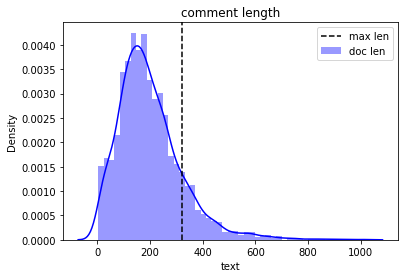

In [32]:
sns.distplot(len, hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [33]:
# 토큰화 기준 설정
max_features = 20000 # 전체 단어들 중 토큰화시킬 단어 수 
max_len = 350 # 토큰화한 text의 vector 길이 제한 

In [34]:
tokenizer = Tokenizer(num_words=max_features) 
tokenizer.fit_on_texts(list(data_en["text"]))

tokenized_text = tokenizer.texts_to_sequences(data_en["text"])
print(tokenized_text[0])

[40, 1117, 1427, 621, 683, 126, 22, 1, 2, 1012, 82, 126, 22, 113, 670, 89, 1967, 832, 8067, 408, 566, 16, 114, 749, 41, 311, 5, 261, 457, 5, 47, 126, 163, 18, 21, 60, 454, 152, 1, 18, 152, 1, 18, 21, 1100, 905, 943, 659, 1012, 82, 21, 621, 14, 117, 48, 64, 1012, 82, 99, 89, 10, 191, 89, 113, 3065, 136, 117, 113, 211, 3, 76, 113, 194, 3, 76, 211, 3, 76, 25, 63, 14, 48, 4058, 1, 18, 189, 67, 4, 245, 2534, 163, 18, 740, 1477, 105, 33, 29, 58, 52, 25, 63, 389, 244, 25, 63, 1005, 3, 55, 878, 40, 1878, 14, 2930, 40, 1878, 276, 277, 25, 63, 5476, 217, 1165, 28, 1630, 412, 11, 1012, 82, 53, 100, 1118, 48, 782, 64, 181, 53, 71, 97, 34, 30, 3, 741, 113, 211, 25, 63, 276, 277, 415, 71, 345, 210, 315, 180, 458, 152, 276, 3567, 104, 642, 276, 193, 265, 535, 275]


In [35]:
data_en['tokenized_text']=tokenized_text 

In [36]:
data_en[:5]

,Unnamed: 0,date,text,tokenized_text
0,0,2020-05-04,future asset treatment accelerate transition e...,"[40, 1117, 1427, 621, 683, 126, 22, 1, 2, 1012..."
1,1,2020-05-04,cylindrical battery mount electric vehicle dev...,"[1006, 3, 459, 1, 6, 1075, 1046, 8068, 6377, 2..."
2,2,2020-05-04,fact electric vehicle integrate state of the a...,"[386, 1, 6, 703, 180, 1601, 1066, 1497, 440, 3..."
3,3,2020-05-04,kona electric select best electric car europea...,"[278, 1, 348, 323, 1, 2, 107, 1746, 1296, 398,..."
4,4,2020-05-04,renault samsung motor say month electric vehic...,"[125, 25, 7, 19, 35, 1, 6, 1241, 887, 2038, 11..."


## padding

In [37]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [38]:
X_news = pad_sequences(data_en["tokenized_text"], maxlen = max_len)

In [39]:
X_train_2D = np.expand_dims(X_train, axis=-1)
X_test_2D = np.expand_dims(X_test, axis=-1)

In [40]:
y_train.shape

(25000,)

## modeling

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [38]:
embed_size = 100
vocab_size=20000

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    inp_ = SpatialDropout1D(dr)(inp_)

    x = Bidirectional(GRU(units, return_sequences = True))(inp_)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(inp_)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(y)

    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)

    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)

    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [41]:
model = build_model(lr = 0.001, lr_d = 0, units = 112, dr = 0.3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 100)     2000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 350, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 350, 224)     143808      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [43]:
# fitting the mdoel 
history = model.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test), verbose = 1 )
#model.load_weights(file_path)

Epoch 1/5
196/196 [==============================] - 239s 1s/step - loss: 0.5747 - accuracy: 0.6468 - val_loss: 0.2877 - val_accuracy: 0.8784
Epoch 2/5
196/196 [==============================] - 192s 980ms/step - loss: 0.2128 - accuracy: 0.9200 - val_loss: 0.2871 - val_accuracy: 0.8859
Epoch 3/5
196/196 [==============================] - 191s 975ms/step - loss: 0.1429 - accuracy: 0.9494 - val_loss: 0.3515 - val_accuracy: 0.8598
Epoch 4/5
196/196 [==============================] - 191s 976ms/step - loss: 0.1065 - accuracy: 0.9623 - val_loss: 0.3227 - val_accuracy: 0.8770
Epoch 5/5
196/196 [==============================] - 191s 974ms/step - loss: 0.0604 - accuracy: 0.9812 - val_loss: 0.5370 - val_accuracy: 0.8566


## modeling

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [46]:
embed_size = 100
vocab_size=20000

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    inp_ = SpatialDropout1D(dr)(inp_)

    x = Bidirectional(GRU(units, return_sequences = True))(inp_)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(inp_)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(y)

    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)

    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)

    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [49]:
model = build_model(lr = 0.0001, lr_d = 0, units = 112, dr = 0.3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 100)     2000000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 350, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 350, 224)     143808      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [50]:
# fitting the mdoel 
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_test, y_test), verbose = 1 )
#model.load_weights(file_path)

Epoch 1/10
782/782 [==============================] - 728s 914ms/step - loss: 0.6285 - accuracy: 0.5961 - val_loss: 0.3103 - val_accuracy: 0.8677
Epoch 2/10
782/782 [==============================] - 679s 868ms/step - loss: 0.2739 - accuracy: 0.8881 - val_loss: 0.2741 - val_accuracy: 0.8830
Epoch 3/10
782/782 [==============================] - 679s 868ms/step - loss: 0.2105 - accuracy: 0.9173 - val_loss: 0.2876 - val_accuracy: 0.8809
Epoch 4/10
782/782 [==============================] - 681s 871ms/step - loss: 0.1747 - accuracy: 0.9349 - val_loss: 0.2993 - val_accuracy: 0.8742
Epoch 5/10
782/782 [==============================] - 682s 872ms/step - loss: 0.1453 - accuracy: 0.9479 - val_loss: 0.3206 - val_accuracy: 0.8796
Epoch 6/10
782/782 [==============================] - 682s 872ms/step - loss: 0.1218 - accuracy: 0.9531 - val_loss: 0.2991 - val_accuracy: 0.8837
Epoch 7/10
782/782 [==============================] - 684s 875ms/step - loss: 0.0977 - accuracy: 0.9647 - val_loss: 0.3345 -

KeyboardInterrupt: ignored

## modeling

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [52]:
embed_size = 100
vocab_size=20000

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    inp_ = SpatialDropout1D(dr)(inp_)

    x = Bidirectional(GRU(units, return_sequences = True))(inp_)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)

    x = SpatialDropout1D(dr)(x)

    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(inp_)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(y)

    x = SpatialDropout1D(dr)(x)

    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(y)


    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)

    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)

    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [55]:
model = build_model(lr = 0.001, lr_d = 0, units = 112, dr = 0.3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 350, 100)     2000000     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 350, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 350, 224)     143808      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [58]:
# fitting the mdoel 
history = model.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_data = (X_test, y_test), verbose = 1 )
#model.load_weights(file_path)

Epoch 1/5
391/391 [==============================] - 737s 2s/step - loss: 0.3439 - accuracy: 0.8510 - val_loss: 0.2760 - val_accuracy: 0.8859
Epoch 2/5
391/391 [==============================] - 730s 2s/step - loss: 0.2037 - accuracy: 0.9208 - val_loss: 0.3009 - val_accuracy: 0.8779
Epoch 3/5
369/391 [===========================>..] - ETA: 26s - loss: 0.1496 - accuracy: 0.9433

KeyboardInterrupt: ignored

## modeling+ embed sizs

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [102]:
embed_size = 350
vocab_size=20000

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [103]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    inp_ = SpatialDropout1D(dr)(inp_)

    x = Bidirectional(GRU(units, return_sequences = True))(inp_)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)

    x = SpatialDropout1D(dr)(x)

    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(inp_)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(y)

    x = SpatialDropout1D(dr)(x)

    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(y)


    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)

    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)

    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [104]:
model = build_model(lr = 0.001, lr_d = 0, units = 112, dr = 0.3)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 350, 350)     7000000     input_15[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_13 (SpatialDr (None, 350, 350)     0           embedding_13[0][0]               
__________________________________________________________________________________________________
bidirectional_27 (Bidirectional (None, 350, 224)     311808      spatial_dropout1d_13[0][0]       
____________________________________________________________________________________________

In [105]:
# fitting the mdoel 
history = model.fit(X_train, Y_train, batch_size = 32, epochs = 5, validation_data = (X_valid, Y_valid), verbose = 1 )
#model.load_weights(file_path)

Epoch 1/5
704/704 [==============================] - 252s 332ms/step - loss: 0.4923 - accuracy: 0.7242 - val_loss: 0.2429 - val_accuracy: 0.9040
Epoch 2/5
704/704 [==============================] - 230s 327ms/step - loss: 0.1932 - accuracy: 0.9258 - val_loss: 0.2522 - val_accuracy: 0.9036
Epoch 3/5
704/704 [==============================] - 231s 328ms/step - loss: 0.1192 - accuracy: 0.9573 - val_loss: 0.3020 - val_accuracy: 0.9004
Epoch 4/5
704/704 [==============================] - 232s 329ms/step - loss: 0.0818 - accuracy: 0.9721 - val_loss: 0.2837 - val_accuracy: 0.8916
Epoch 5/5
704/704 [==============================] - 231s 327ms/step - loss: 0.0568 - accuracy: 0.9791 - val_loss: 0.3281 - val_accuracy: 0.8900


## modeling+ embed sizs

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [42]:
embed_size = 350
vocab_size=20000

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [45]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    inp_ = SpatialDropout1D(dr)(inp_)

    x = Bidirectional(GRU(units, return_sequences = True))(inp_)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "same", kernel_initializer = "he_uniform")(x)

    x = SpatialDropout1D(dr)(x)

    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Bidirectional(GRU(units, return_sequences = True))(x)
    x = Conv1D(int(units/2), kernel_size = 3, padding = "same", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(inp_)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "same", kernel_initializer = "he_uniform")(y)

    x = SpatialDropout1D(dr)(x)

    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Bidirectional(LSTM(units, return_sequences = True))(y)
    y = Conv1D(int(units/2), kernel_size = 3, padding = "same", kernel_initializer = "he_uniform")(y)


    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)

    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)

    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [46]:
model = build_model(lr = 0.001, lr_d = 0, units = 112, dr = 0.3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 350)     7000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 350, 350)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 350, 224)     311808      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [47]:
# fitting the mdoel 
history = model.fit(X_train, Y_train, batch_size = 32, epochs = 5, validation_data = (X_valid, Y_valid), verbose = 1 )
#model.load_weights(file_path)

Epoch 1/5
288/704 [===========>..................] - ETA: 54:18 - loss: 0.6395 - accuracy: 0.5778

KeyboardInterrupt: ignored

## modeling + nomalization, learning rate, batch, early sop

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [54]:
embed_size = 100
vocab_size=20000

In [55]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [57]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    x = Embedding(vocab_size,embed_size)(inp)
    x1 = SpatialDropout1D(dr)(x)

    x = Bidirectional(GRU(units, return_sequences = True))(x1)
    x = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(x1)
    y = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)

    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)

    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)

    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [58]:
model = build_model(lr = 0.0005, lr_d = 0, units = 112, dr = 0.3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 100)     2000000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 350, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 350, 224)     143808      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [59]:
file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=3)

callbacks_list = [checkpoint, early] #early stopping 

In [60]:
# fitting the mdoel 
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, Y_valid), 
                        verbose = 1 , callbacks=callbacks_list)
model.load_weights(file_path)

Epoch 1/10
176/176 [==============================] - 30s 141ms/step - loss: 0.6370 - accuracy: 0.5896 - val_loss: 0.2896 - val_accuracy: 0.8848

Epoch 00001: val_loss improved from inf to 0.28962, saving model to weights_base.best.hdf5
Epoch 2/10
176/176 [==============================] - 24s 137ms/step - loss: 0.2584 - accuracy: 0.8973 - val_loss: 0.2444 - val_accuracy: 0.9044

Epoch 00002: val_loss improved from 0.28962 to 0.24438, saving model to weights_base.best.hdf5
Epoch 3/10
176/176 [==============================] - 24s 138ms/step - loss: 0.1772 - accuracy: 0.9346 - val_loss: 0.2432 - val_accuracy: 0.8992

Epoch 00003: val_loss improved from 0.24438 to 0.24315, saving model to weights_base.best.hdf5
Epoch 4/10
176/176 [==============================] - 24s 137ms/step - loss: 0.1280 - accuracy: 0.9559 - val_loss: 0.2542 - val_accuracy: 0.8984

Epoch 00004: val_loss did not improve from 0.24315
Epoch 5/10
176/176 [==============================] - 24s 136ms/step - loss: 0.0935 

## modeling

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D, Reshape

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [36]:
embed_size = 100
vocab_size=20000

In [40]:
from tensorflow.keras.applications import ResNet152V2

In [86]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (350,1))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    
    inp_ = Reshape((max_len, embed_size, 1))(inp_)
    model = ResNet152V2(include_top=False, weights=None,  input_tensor=inp_)

    #x = BatchNormalization(model.output)
    x = SpatialDropout2D(dr)(model.output)
    x = Flatten()(x)
    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = model.input, outputs = x)
    
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [87]:
model = build_model(lr = 0.001, lr_d = 0, units = 112, dr = 0.4)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 350, 1)]     0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 350, 1, 100)  2000000     input_18[0][0]                   
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 350, 100, 1)  0           embedding_17[0][0]               
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 356, 106, 1)  0           reshape_12[0][0]                 
____________________________________________________________________________________________

In [72]:
# fitting the mdoel 
history = model.fit(X_train_2D, y_train, batch_size = 32, epochs = 5, validation_data = (X_test_2D, y_train), verbose = 1 )
#model.load_weights(file_path)

Epoch 1/5
  3/782 [..............................] - ETA: 9:35:30 - loss: 7.7181 - accuracy: 0.5590

KeyboardInterrupt: ignored

In [46]:
X_train_2D.shape

(25000, 350, 1)

In [ ]:
def plot_hist(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

In [ ]:
plot_hist(history)

In [ ]:
def build_model(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    x = data_augmentation(inputs)
    model = ResNet50V2(include_top=False, weights="imagenet", input_tensor=x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(model.inputs, outputs, name="ResNet50V2")

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

## modeling

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D, Reshape

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [66]:
from sklearn.model_selection import train_test_split
X_train_2D, X_valid_2D, Y_train, Y_valid = train_test_split(X_train_2D, y_train, test_size = 0.1)

ValueError: ignored

In [70]:
X_valid_2D.shape

(2500, 350, 1)

In [41]:
embed_size = 100
vocab_size=20000

In [46]:
from tensorflow.keras.applications import MobileNetV2

In [47]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (350,1))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    
    inp_ = Reshape((max_len, embed_size, 1))(inp_)
    model = MobileNetV2(include_top=False, weights=None, classes=2, input_tensor=inp_)

    #x = BatchNormalization(model.output)
    x = SpatialDropout2D(dr)(model.output)
    x = Flatten()(x)
    x = Dense(64, activation = "relu")(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = model.input, outputs = x)
    
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [48]:
model = build_model(lr = 0.001, lr_d = 0, units = 112, dr = 0.4)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 350, 1)]     0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 350, 1, 100)  2000000     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 350, 100, 1)  0           embedding_2[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 175, 50, 32)  288         reshape_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
# fitting the mdoel 
history = model.fit(X_train_2D, Y_train, batch_size = 128, epochs = 5, validation_data = (X_valid_2D, Y_valid), verbose = 1 )

Epoch 1/5
176/176 [==============================] - 3496s 20s/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 2/5
176/176 [==============================] - 3492s 20s/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 3/5
176/176 [==============================] - 3505s 20s/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 4/5
176/176 [==============================] - 3520s 20s/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 5/5
  9/176 [>.............................] - ETA: 54:53 - loss: 0.6931 - accuracy: 0.5104

In [ ]:
X_train_2D.shape

In [ ]:
def plot_hist(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

In [ ]:
plot_hist(history)

In [ ]:
def build_model(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    x = data_augmentation(inputs)
    model = ResNet50V2(include_top=False, weights="imagenet", input_tensor=x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(model.inputs, outputs, name="ResNet50V2")

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

## modeling

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten,  Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, LeakyReLU, Softmax, MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv1D, SpatialDropout1D, SpatialDropout2D, LocallyConnected1D
from tensorflow.keras.layers import Activation, GRU,GlobalMaxPooling1D, Reshape,MaxPool2D

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, LearningRateSchedule


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [53]:
embed_size = 100
vocab_size=20000

In [74]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (350,1))
    inp_ = Embedding(vocab_size,embed_size)(inp)
    x = Reshape((max_len, embed_size, 1))(inp_)

    conv_0 = Conv2D(32, kernel_size=(9, embed_size),padding = "same", kernel_initializer='normal',activation='relu')(x)
    conv_1 = Conv2D(32, kernel_size=(9, embed_size),padding = "same", kernel_initializer='normal',activation='relu')(x)
    conv_2 = Conv2D(32, kernel_size=(6, embed_size),padding = "same", kernel_initializer='normal',activation='relu')(x)
    conv_3 = Conv2D(32, kernel_size=(3, embed_size),padding = "same", kernel_initializer='normal',activation='relu')(x)
    
    maxpool_0 = MaxPool2D()(conv_0)
    maxpool_1 = MaxPool2D()(conv_1)
    maxpool_2 = MaxPool2D()(conv_2)
    maxpool_3 = MaxPool2D()(conv_3)
        
    z = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    z = Dense(64, activation = "relu")(z)
    outp = Dense(1, activation="sigmoid")(z)

    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])


    model.summary()
    return model

In [75]:
model = build_model(lr = 0.001, lr_d = 0, units = 112, dr = 0.4)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 350, 1)]     0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 350, 1, 100)  2000000     input_10[0][0]                   
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 350, 100, 1)  0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 350, 100, 32) 28832       reshape_9[0][0]                  
____________________________________________________________________________________________

In [ ]:
# fitting the mdoel 
history = model.fit(X_train_2D, Y_train, batch_size = 128, epochs = 5, validation_data = (X_valid_2D, Y_valid), verbose = 1 )

Epoch 1/5
  1/176 [..............................] - ETA: 11:10:01 - loss: 0.6909 - accuracy: 0.6250

In [ ]:
X_train_2D.shape

In [ ]:
def plot_hist(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

In [ ]:
plot_hist(history)

In [ ]:
def build_model(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    x = data_augmentation(inputs)
    model = ResNet50V2(include_top=False, weights="imagenet", input_tensor=x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(model.inputs, outputs, name="ResNet50V2")

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

## predict

In [ ]:
def sentiment_predict(score): # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 text입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 text입니다.\n".format((1 - score) * 100))
  return score

In [ ]:
preds = []
score=model.predict(X_news).flatten()
for sentence in score:
    preds.append(sentence)

In [ ]:
data_en['sentimental']=preds

In [ ]:
data_en

,text,tokenized_text,sentimental
date,,,
2020-11-03,recent years fire accident electric car batter...,"[211, 299, 160, 1136, 1, 2, 5, 2874, 5, 574, 1...",0.467651
2020-11-03,china spur expansion new energy automobile ele...,"[47, 1036, 153, 11, 30, 94, 1, 23, 43, 371, 11...",0.010228
2020-11-03,credit guarantee fund support cooperative ente...,"[1501, 1155, 305, 70, 1962, 487, 498, 1, 8, 67...",0.033442
2020-11-03,year global electric car sales volume year rec...,"[3, 27, 1, 2, 25, 146, 3, 282, 273, 84, 723, 2...",0.072722
2020-11-03,accord industry global electric car market rap...,"[43, 26, 27, 1, 2, 6, 248, 113, 29, 1, 2, 5, 4...",0.980676
...,...,...,...
2021-04-30,sk innovation collaborate sk car renta create ...,"[56, 91, 1574, 56, 2, 1817, 317, 1320, 120, 73...",0.098282
2021-04-30,lg energy solutions lotte rentals hand hand el...,"[21, 30, 157, 326, 1221, 417, 417, 1, 16, 1665...",0.015128
2021-04-30,domestic electric vehicle market must ship fir...,"[55, 1, 4, 6, 953, 350, 14, 14, 3, 111, 2221, ...",0.000086


In [ ]:
data_sentiment=data_en.groupby('date').mean()
data_sentiment

,sentimental
date,
2020-11-03,0.324995
2020-11-04,0.550435
2020-11-05,0.257808
2020-11-06,0.356842
2020-11-09,0.328151
...,...
2021-04-26,0.300549
2021-04-27,0.176617
2021-04-28,0.308413


In [ ]:
data_sentiment.to_csv(r"/content/drive/MyDrive/금융시장빅데이터분석/data_sentiment.csv")

In [ ]:
timeseries=pd.DataFrame({'sentiment':data_sentiment['sentimental'],"news_num":news_num, "hyundai" : hyundai, "kia":kia }, index=date_index)
timeseries

,sentiment,news_num,hyundai,kia
2020-11-01,0.112355,5,1,0
2020-11-02,0.433104,12,0,0
2020-11-03,0.200482,11,0,0
2020-11-04,0.073482,11,0,1
2020-11-05,0.739916,4,0,0
...,...,...,...,...
2021-04-26,0.519635,27,1,3
2021-04-27,0.201931,19,0,1
2021-04-28,0.593208,15,0,1
2021-04-29,0.289751,20,1,6


In [ ]:
timeseries.to_csv(r"/content/drive/MyDrive/금융시장빅데이터분석/timeseries.csv")

NameError: ignored